# Building a biorefinery

Putting it all together, we can finally build a complete biorefinery from scratch. The following examples should help guide this process.

## Sugarcane biorefinery

In this example, a sugarcane biorefinery for the production of ethanol is designed according to [[1]](#References), including all process setings, prices, and assumptions. Some heat integration is not included here for simplicity.

### Thermodynamic property package

First create the thermodynamic property package to define the chemicals in the process. We can follow the [example](https://thermosteam.readthedocs.io/en/latest/tutorial/Thermo_property_packages.html) in Thermosteam's docs to do this:

In [1]:
import biosteam as bst

chemicals = bst.Chemicals(
    ['Water', # Define common chemicals by name
     'Ethanol',
     'Octane',
     bst.Chemical('Glucose', phase='s'), # Set the phase for chemicals not in vapor-liquid equilibrium
     bst.Chemical('Sucrose', phase='s'),
     bst.Chemical('H3PO4', phase='s'),
     bst.Chemical('P4O10',
                  rho=1540, # Density [kg/m3]
                  default=True,  # Default other chemicals properties like viscosity to that of water at 25 C  
                  phase='s'),
     bst.Chemical('CO2', phase='g'),
     bst.Chemical('O2', phase='g'),
     bst.Chemical('Cellulose',
                  Cp=1.364, # Heat capacity [kJ/kg]
                  rho=1540, # Density [kg/m3]
                  default=True, # Default other chemicals properties like viscosity to that of water at 25 C 
                  search_db=False, # Not in database, so do not search the database
                  phase='s',
                  formula="C6H10O5", # Glucose monomer minus water, molecular weight is computed based on formula
                  Hf=-975708.8), # Heat of formation [J/mol]
     bst.Chemical('Hemicellulose',
                  Cp=1.364,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  formula="C5H8O5", # Xylose monomer minus water
                  Hf=-761906.4),
     bst.Chemical('Lignin',
                  Cp=1.364,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  formula='C8H8O3', # Vainillin formula
                  Hf=-452909.632),
     bst.Chemical('Flocculant',
                  Cp=4.184,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  MW=1.), # No formula, so molecular weight should be defined
     bst.Chemical('Solids',
                  Cp=1.100,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  MW=1.),
     bst.Chemical('DryYeast',
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  MW=1.,
                  synonyms={'Yeast'}),
     bst.Chemical('CaO',
                  Cp=1.02388,
                  rho=1540,
                  default=True,
                  search_db=False,
                  phase='s',
                  formula='CaO'),
     bst.Chemical('Ash', 
                  rho=1540,
                  Cp=0.37656,
                  default=True,
                  search_db=False,
                  phase='s',
                  MW=1.)]
)
bst.settings.set_thermo(chemicals)

### Process settings

Before any simulations, we define the conditions of all our utilities and the Chemical Engineering Plant Cost Indes (CEPCI):

In [2]:
bst.CE = 567 # CEPCI: 2013
bst.PowerUtility.price = 0.065
HeatUtility = bst.HeatUtility
# Steam is produced on-site by a boiler,
# so make it the only available heating agent.
steam_utility = HeatUtility.get_agent('low_pressure_steam')
HeatUtility.heating_agents = [steam_utility]
steam_utility.heat_transfer_efficiency = 0.85
steam_utility.T = 529.2
steam_utility.P = 44e5

# Steam, cooling water, and chilled water are regenerated by
# on-site facilities. The regeneration and heat transfer
# prices are given accounted for by the capital cost and
# electricity consumption of these facilities
steam_utility.regeneration_price = 0.
HeatUtility.get_agent('cooling_water').regeneration_price = 0
HeatUtility.get_agent('chilled_water').heat_transfer_price = 0

# Raw material price (USD/kg)
price = {'Sugar cane': 0.03455, # 70% m.c
         'Water': 0.000353,
         'HCl': 0.205,
         'Lime': 0.077,
         'H3PO4': 0, # Not significant
         'NaOH':0.41,
         'Protease': 0.5,
         'Polymer': 0, # Not significant
         'Steam': 0.017,
         'Ethanol': 0.789,
         'Waste': -0.33,
         'Gasoline': 0.756} # 2 USD/gal

### Unit operations and simulation

First define the unit operations for feedstock handling and juicing:

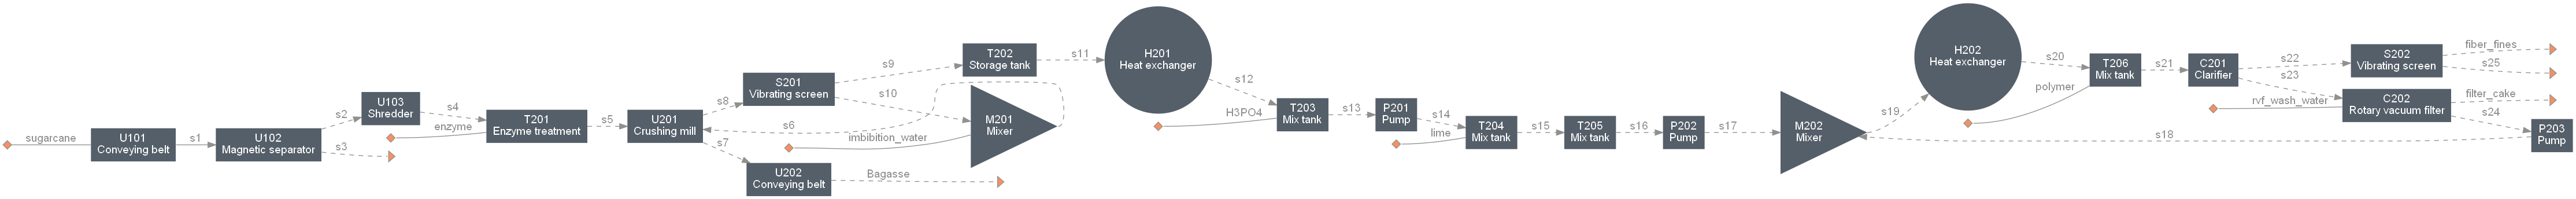

In [3]:
from biosteam import units
import numpy as np

bst.main_flowsheet.set_flowsheet('sugarcane_ethanol')
chemicals.define_group( # We can create streams and set component splits faster by defining chemical groups
    name='Fiber',
    IDs=['Cellulose', 'Hemicellulose', 'Lignin'],
    composition=[0.4704 , 0.2775, 0.2520],
    wt=True, # Composition is given as weight
)
chemicals.define_group(
    name='Sugar',
    IDs=['Sucrose', 'Glucose'],
    # Default composition as equimolar
)

sugarcane = bst.Stream(
    'sugarcane',
    Water=0.7,
    Glucose=0.01208,
    Sucrose=0.1369,
    Ash=0.006,
    Fiber=0.13,
    Solids=0.015,
    total_flow=333334.2,
    units='kg/hr',
    price=price['Sugar cane']
)

enzyme = bst.Stream('enzyme',
                    Cellulose=100, Water=900, units='kg/hr',
                    price=price['Protease'])

imbibition_water = bst.Stream('imbibition_water',
                              Water=87023.35, units='kg/hr',
                              T = 338.15)

H3PO4 = bst.Stream('H3PO4',
                   H3PO4=74.23, Water=13.10, units='kg/hr',
                   price=price['H3PO4'])  # to T203

lime = bst.Stream('lime',
                  CaO=333.00, Water=2200.00, units='kg/hr',
                  price=price['Lime'])  # to P5

polymer = bst.Stream('polymer',
                     Flocculant=0.83, units='kg/hr',
                     price=price['Polymer'])  # to T205

rvf_wash_water = bst.Stream('rvf_wash_water',
                            Water=16770, units='kg/hr',
                            T=363.15)  # to C202

### Unit operations ###

# Feed the shredder
U101 = units.ConveyingBelt('U101', sugarcane)

# Separate metals
U102 = units.MagneticSeparator('U102', U101-0)

# Shredded cane
U103 = units.Shredder('U103', U102-0)

# Hydrolyze starch
T201 = units.EnzymeTreatment('T201', [U103-0, enzyme], T=323.15)  # T=50

# Finely crush lipid cane
imbibition_water_recycle = bst.Stream() # To connect later
U201 = units.CrushingMill('U201', [T201-0, imbibition_water_recycle],
                          split=dict(Ash=0.92,
                                     Fiber=0.92,
                                     Sugar=0.04,
                                     Solids=1),
                          moisture_content=0.5)

# Convey out bagasse
U202 = units.ConveyingBelt('U202', U201-0, outs='Bagasse')

# Screen out fibers
S201 = units.VibratingScreen('S201', U201-1,
                             split=dict(Ash=0.35,
                                        Fiber=0.35,
                                        Sugar=0.88,
                                        Water=0.88,
                                        Solids=0))

# Mix in water
M201 = units.Mixer('M201', [S201-1, imbibition_water], imbibition_water_recycle)

# Store juice before treatment
T202 = units.StorageTank('T202', S201-0, tau=4, vessel_material='Carbon steel')

# Heat up before adding acid
H201 = units.HXutility('H201', T202-0, T=343.15)

# Mix in acid
T203 = units.MixTank('T203', [H201-0, H3PO4])

# Pump acid solution
P201 = units.Pump('P201', T203-0)

# Mix lime solution
T204 = units.MixTank('T204', [P201-0, lime], tau=0.10)

# Blend acid lipid solution with lime
T205 = units.MixTank('T205', T204-0, tau=0.10)
P202 = units.Pump('P202', T205-0)

# Mix recycle
RVF_recycle = bst.Stream() # From rotary vacuum filter; connect later
M202 = units.Mixer('M202', [P202-0, RVF_recycle])

# Heat before adding flocculant
H202 = units.HXutility('H202', M202-0, T=372.15)

# Mix in flocculant
T206 = units.MixTank('T206', [H202-0, polymer])
T206.tau = 0.10

# Separate residual solids
C201 = units.Clarifier('C201', T206-0,
                       split=dict(Ash=0,
                                  CaO=0,
                                  Fiber=0,
                                  Flocculant=0.522,
                                  Sugar=0.522,
                                  H3PO4=0.522,
                                  Water=0.522))

# Remove solids as filter cake
C202 = units.RVF('C202', [C201-1, rvf_wash_water],
                 outs=('filter_cake', ''),
                 moisture_content=0.80,
                 split=dict(Ash=0.85,
                            CaO=0.85,
                            Fiber=0.85,
                            Sugar=0.01))
P203 = units.Pump('P203', C202-1, RVF_recycle)


# Screen out small fibers from sugar stream
S202 = units.VibratingScreen('S202', C201-0,
                             outs=('', 'fiber_fines'),
                             split=dict(Ash=1.0,
                                        CaO=1.0,
                                        Fiber=1.0,
                                        Flocculant=0.0,
                                        Sugar=0.998,
                                        H3PO4=1.0,
                                        Water=0.998))
S202.mesh_opening = 2

### Process specifications ###

# Specifications dependent on lipid cane flow rate
@U103.add_specification(run=True) # Run unit operation afterwords
def correct_flows():
    feedstock = U101.ins[0]
    F_mass = feedstock.F_mass
    # correct enzyme, lime, phosphoric acid, and imbibition water
    enzyme.imass['Cellulose', 'Water'] = 0.003 * F_mass * np.array([0.1, 0.9])
    lime.imass['CaO', 'Water'] = 0.001 * F_mass * np.array([0.046, 0.954])
    H3PO4.imass['H3PO4', 'Water'] = 0.00025 * F_mass
    imbibition_water.imass['Water'] = 0.25* F_mass

# Specifications within a system
@P202.add_specification(run=True)
def correct_wash_water():
    solids = P202.ins[0].imol['Ash', 'CaO', 'Fiber'].sum()
    rvf_wash_water.imol['Water'] = 0.0574 * solids

bst.main_flowsheet.diagram() # Flow sheet up until now

Define unit operations for ethanol production from juice:

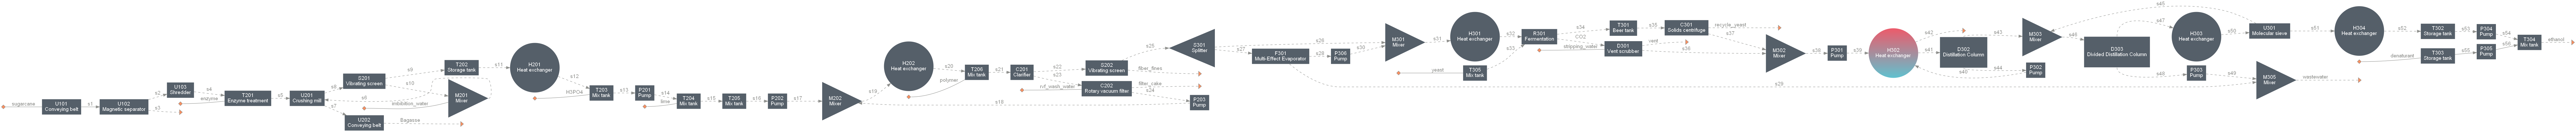

In [4]:
import flexsolve as flx # Package with numerical solvers similar to scipy

### Streams ###
    
# Fresh water
stripping_water = bst.Stream('stripping_water', Water=5000, units='kg/hr')

# Gasoline
denaturant = bst.Stream('denaturant', Octane=230.69,
                        units='kg/hr', price=price['Gasoline'])

sugar_solution = S202-0

# Yeast
yeast = bst.Stream('yeast', Water=24700, DryYeast=10300, units='kg/hr')

# Ethanol product
ethanol = bst.Stream('ethanol', price=price['Ethanol'])

### Units ###

# Split sugar solution
S301 = units.Splitter('S301', sugar_solution, split=0.10)

# Concentrate sugars
F301 = units.MultiEffectEvaporator('F301', S301-1,
                                   P=(101325, 73581, 50892, 32777),
                                   V_definition='First-effect',
                                   V=0.1) # fraction evaporated
P306 = units.Pump('P306', F301-0)

# Mix sugar solutions
M301 = units.Mixer('M301', [P306-0, S301-0])

def get_sugar_concentration():
    s = M301.outs[0]
    if 'Lipid' in s.chemicals:
        ignored = float(s.imass['Lipid'])
    else:
        ignored = 0.
    return s.imass['Glucose', 'Sucrose'].sum() / (s.F_mass - ignored)
    
def sugar_concentration_at_fraction_evaporated(V):
    F301.V = V
    for i in F301.path_until(M301): i._run()
    M301._run()
    return F301.sugar_concentration - get_sugar_concentration()

@F301.add_specification
def adjust_sugar_concentration():
    # Solve for vapor fraction that gets the required sugar concentration
    F301.V = flx.IQ_interpolation(
        f=sugar_concentration_at_fraction_evaporated,
        x0=0., 
        x1=1., 
        ytol=0.01
    )
    
F301.sugar_concentration = 0.23 # wt. % sugar

# Cool for fermentation
H301 = units.HXutility('H301', M301-0, T=295.15)

# Yeast preparation
T305 = units.MixTank('T305', yeast)
T305.tau = 0.1

# Ethanol Production
R301 = units.Fermentation('R301', [H301-0, T305-0], outs=('CO2', ''), tau=9, efficiency=0.90, N=4) 
R301.cell_growth_reaction.X = 0. # Ignore for simplicity
T301 = units.StorageTank('T301', R301-1, tau=4, vessel_material='Carbon steel')
T301.line = 'Beer tank' # Changes name on the diagram

D301 = units.VentScrubber('D301', ins=(stripping_water, R301-0), 
                          outs=('vent', ''),
                          gas=('CO2',))

# Separate 99% of yeast
C301 = units.SolidsCentrifuge('C301', T301-0, outs=('', 'recycle_yeast'),
                            split=(1, 0.99999, 1, 0.01),
                            order=('Ethanol', 'Glucose', 'H3PO4', 'DryYeast'),
                            solids=('DryYeast',))

# Add bottoms from scrubber
M302 = units.Mixer('M302', [C301-0, D301-1])
P301 = units.Pump('P301', M302-0)

# Heat up before beer column
# Exchange heat with stillage
bottoms_product = bst.Stream() # Bottoms product from beer column, connect later
H302 = units.HXprocess('H302', [P301-0, bottoms_product], U=1.28)

# Beer column
D302 = units.BinaryDistillation('D302', H302-0, P=101325,
                                Lr=0.99999, Hr=0.60, # Light and heavy key recoveries
                                LHK=('Ethanol', 'Water'), # Light and heavy key
                                k=1.25) # Actual reflux over minimum reflux ratio
D302.tray_material = 'Stainless steel 304'
D302.vessel_material = 'Stainless steel 304'
D302.boiler.U = 1.85
P302 = units.Pump('P302', D302-1, bottoms_product)

# Mix ethanol Recycle (Set-up)
molecular_sieve_recycle = bst.Stream()
M303 = units.Mixer('M303', [D302-0, molecular_sieve_recycle])

D303 = units.BinaryDistillation('D303', M303-0, P=101325,
                            y_top=0.80805, x_bot=3.91e-06,  # Molar fraction of light key in the distillate and bottoms product
                            k=1.25,
                            LHK=('Ethanol', 'Water'),
                            tray_material='Stainless steel 304',
                            vessel_material='Stainless steel 304',
                            is_divided=True)
D303.boiler.U = 1.85
P303 = units.Pump('P303', D303-1)

# Superheat vapor for mol sieve
H303 = units.HXutility('H303', D303-0, T=115+273.15, V=1, heat_only=True)

# Molecular sieve
U301 = units.MolecularSieve('U301', H303-0, [molecular_sieve_recycle, ''],
                            split=dict(Ethanol=0.1621,
                                       Water=0.925))

# Condense ethanol product
H304 = units.HXutility('H304', U301-1, V=0, T=340.)
T302 = units.StorageTank('T302', H304-0, tau=7*24, # 1 week storage capacity
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P304 = units.Pump('P304', T302-0)

# Storage for denaturant
T303 = units.StorageTank('T303', denaturant, tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P305 = units.Pump('P305', T303-0)

# Denatured ethanol product
T304 = units.MixTank('T304', [P305-0, P304-0], outs=ethanol)
T304.tau = 0.10 # 6 min residence time

# Waste water
M305 = units.Mixer('M305', [P303-0, F301-1], outs='wastewater')

@P304.add_specification(run=True)
def adjust_denaturant():
    pure_ethanol = P304.ins[0]
    denaturant.imol['Octane'] = 0.021*pure_ethanol.F_mass/114.232

bst.main_flowsheet.diagram('thorough') # Flow sheet up until now

Define facilities which use data from unit operations to solve for utility requirements:

In [5]:
s = bst.main_flowsheet.stream
BT = units.BoilerTurbogenerator('BT',
                                (U202-0, '', 'boiler_makeup_water', 'natural_gas', '', ''),
                                boiler_efficiency=0.80,
                                turbogenerator_efficiency=0.85)

CT = units.CoolingTower('CT')
makeup_water = bst.Stream('makeup_water', price=0.000254)

CWP = units.ChilledWaterPackage('CWP')
PWC = units.ProcessWaterCenter('PWC',
                               ins=(bst.Stream(), makeup_water),
                               outs=(),
                               makeup_water_streams=(s.cooling_tower_makeup_water,
                                                     s.boiler_makeup_water),
                               process_water_streams=(imbibition_water,
                                                      rvf_wash_water,
                                                      stripping_water,
                                                      s.cooling_tower_makeup_water,
                                                      s.boiler_makeup_water))

Create the system and simulate:

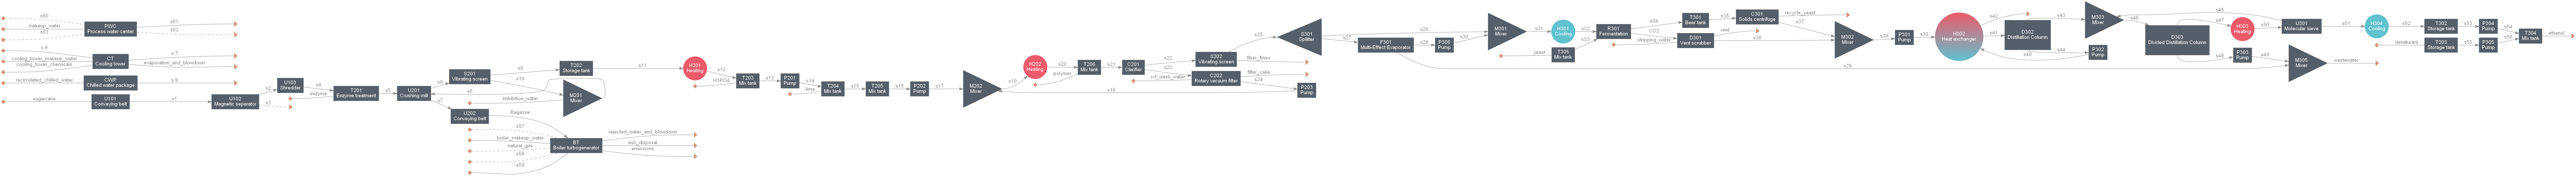

In [6]:
sugarcane_sys = bst.main_flowsheet.create_system('sugarcane_sys')
sugarcane_sys.simulate()
sugarcane_sys.diagram('thorough', format='png')

BioSTEAM generates nested systems to solve recycle streams more robustly. It may be fun to view these systems as follows:

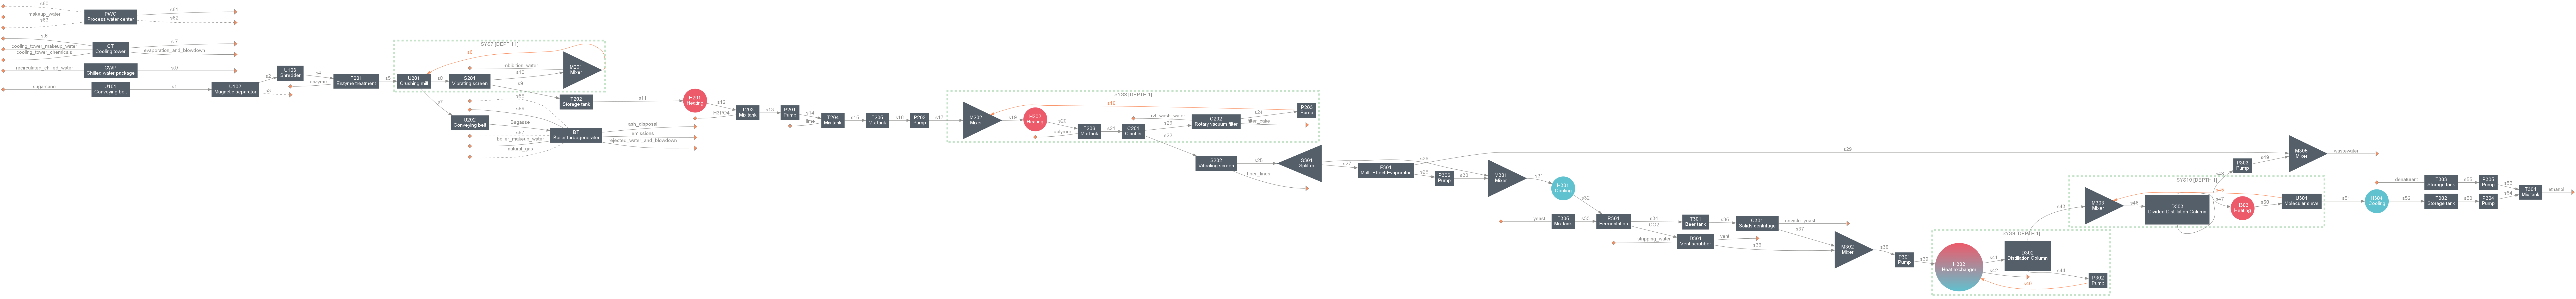

In [7]:
sugarcane_sys.diagram('cluster', format='png') # Red streams are recycles (i.e. tear streams)

In [8]:
sugarcane_sys.print()

System('sugarcane_sys',
    [U101,
     U102,
     U103,
     T201,
     System('SYS7',
        [U201,
         S201,
         M201],
        recycle=M201-0),
     T202,
     H201,
     T203,
     P201,
     T204,
     T205,
     P202,
     System('SYS8',
        [M202,
         H202,
         T206,
         C201,
         C202,
         P203],
        recycle=P203-0),
     S202,
     S301,
     F301,
     P306,
     M301,
     H301,
     T305,
     R301,
     T301,
     C301,
     D301,
     M302,
     P301,
     System('SYS9',
        [H302,
         D302,
         P302],
        recycle=P302-0),
     System('SYS10',
        [M303,
         D303,
         H303,
         U301],
        recycle=U301-0),
     H304,
     T302,
     P304,
     T303,
     P305,
     T304,
     P303,
     M305,
     U202],
    facilities=[BT,
     CWP,
     CT,
     PWC])


### Biorefinery characterization

Generate a breakdown of results by biorefinery area with BioSTEAM's UnitGroup objects:

In [9]:
UnitGroup = bst.process_tools.UnitGroup
juicing = UnitGroup('Juicing', 
                    [U101, U102, U103, T201,
                     U201, S201, M201, T202,
                     H201, T203, P201, T204,
                     T205, P202, M202, H202,
                     T206, C201, C202, P203,
                     S202])
ethanol_production = UnitGroup('Ethanol production',
                               [S301, F301, P306, M301,
                                H301, T305, R301, T301,
                                C301, M302, P301, H302,
                                D302, P302, M303, D303,
                                H303, U301, H304, T302,
                                P304, T303, P305, T304,
                                D301, P303, M305])
facilities = UnitGroup('Facilities', sugarcane_sys.facilities)
groups = [juicing, ethanol_production, facilities]
print(UnitGroup.df_from_groups(groups))


                    Installed equipment cost [MM$]  Cooling duty [GJ/hr]  \
Juicing                                       19.4                     0   
Ethanol production                            16.9                   201   
Facilities                                    69.1                    83   

                    Heating duty [GJ/hr]  Electricity consumption [MW]  \
Juicing                              113                          4.39   
Ethanol production                   183                         0.631   
Facilities                             0                          4.53   

                    Materiral cost [USD/hr]  
Juicing                             1.2e+04  
Ethanol production                      362  
Facilities                             35.7  


In [10]:
# It is also possible to automatically group units by area
area_groups = UnitGroup.group_by_area(sugarcane_sys.units)

# Use short names for metrics
for group in area_groups: group.autofill_metrics(shorthand=True)

area_names = {'0': 'Facilities',
              '100': 'Feedstock handling',
              '200': 'Juicing',
              '300': 'Ethanol production'}
for i in area_groups: i.name = area_names[i.name]
print(UnitGroup.df_from_groups(area_groups))

                    Inst. eq. cost [MM$]  Cooling [GJ/hr]  Heating [GJ/hr]  \
Facilities                          69.1               83                0   
Feedstock handling                  5.04                0                0   
Juicing                             14.4                0              113   
Ethanol production                  16.9              201              183   

                    Elec. cons. [MW]  Mat. cost [USD/hr]  
Facilities                      4.53                35.7  
Feedstock handling              2.01            1.15e+04  
Juicing                         2.38                 526  
Ethanol production             0.631                 362  


(<Figure size 432x288 with 3 Axes>,
 array([<AxesSubplot:ylabel='Cost and Utility Breakdown [%]'>],
       dtype=object))

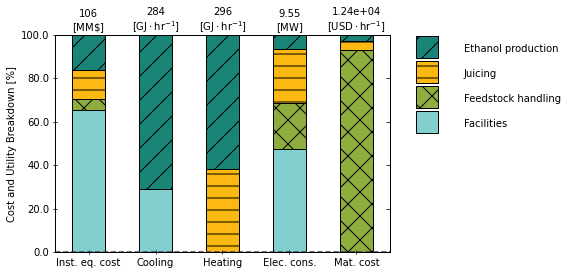

In [11]:
# For convinience, BioSTEAM has plotting methods centered on UnitGroup objects
bst.plots.plot_unit_groups(area_groups, fraction=True)

### References

<a id='References'></a>

1. Huang, H., Long, S., & Singh, V. (2016) "Techno-economic analysis of biodiesel and ethanol co-production from lipid-producing sugarcane" Biofuels, Bioproducts and Biorefining, 10(3), 299–315. https://doi.org/10.1002/bbb.1640